## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=500, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=15,     # Number of steps each sampled episode should contain
    batchSize=40,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=4.0, noiseLevel=0.05)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.05),
#             GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.GAS, minPower=0.5, maxPower=2.0, noiseLevel=0.05),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='3Gens-CostFrequency-0_5k-c1'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=4.0, noiseLevel=0.05)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=300.0, beta=5, gamma=0.001), minPower=0.5, maxPower=2.0, noiseLevel=0.05), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=500.0, beta=8, gamma=0.00194), minPower=0.5, maxPower=2.0, noiseLevel=0.05)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=500, maxSteps=100, bufferSize=500, traceLength=15, batchSize=40, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='3Gens-CostFrequency-0_5k')

Train Agents

In [18]:
def rewardFn(deltaFreq, totalCost):
    scaledCost = totalCost/(1000.0) # Scale down cost to levels near the ones found in output differential (e.g. 10 */ 10)
    costComponent = 2**(-1*(scaledCost**2)/50)
    freqComponent = 8*2**(-1*(deltaFreq**2)/2) + 2**(-1*(deltaFreq**2)/100)
    earnedReward = costComponent*freqComponent
    
    print(f'Scaled_Cost:{scaledCost} - deltaFreq:{deltaFreq} - costComponent:{costComponent} - freqComponent:{freqComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'freq': freqComponent, 'total': earnedReward}

In [20]:
from learning.cost_frequency import ModelAdapterCostFrequency as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0916 01:50:25.912590 139881689122560 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0916 01:50:25.914175 139881689122560 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0916 01:50:25.943048 139881689122560 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: 3Gens-CostFrequency-0_5k - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/3Gens-CostFrequency-0_5k/model
CPU times: user 1h 28min, sys: 9min 48s, total: 1h 37min 49s
Wall time: 1h 4min 51s


In [21]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

Scaled_Cost:2.007519366151726 - deltaFreq:32.17148852748946 - costComponent:0.9456625174478327 - freqComponent:0.0007661705851409799 - reward:0.000724538804338898
Scaled_Cost:2.143171856156223 - deltaFreq:-32.30524394306782 - costComponent:0.9383098321669029 - freqComponent:0.0007217126375701144 - reward:0.0006771900638311469
Scaled_Cost:2.007519366151726 - deltaFreq:22.409822055972185 - costComponent:0.9456625174478327 - freqComponent:0.030777049763719613 - reward:0.029104702359176313
Scaled_Cost:2.143171856156223 - deltaFreq:-8.700071935476288 - costComponent:0.9383098321669029 - freqComponent:0.5917613934720187 - reward:0.5552555337915824
Scaled_Cost:2.007519366151726 - deltaFreq:-5.7009340340788555 - costComponent:0.9456625174478327 - freqComponent:0.7983974213762975 - reward:0.7550145154225676
Scaled_Cost:1.8724548761647533 - deltaFreq:14.914949356517155 - costComponent:0.9525576108039293 - freqComponent:0.2139644259372578 - reward:0.20381344236782858
Scaled_Cost:2.007516773332546

Scaled_Cost:1.45735 - deltaFreq:-0.3064307962880548 - costComponent:0.9709861480014923 - freqComponent:8.743194387851347 - reward:8.489520639888044
Scaled_Cost:1.45735 - deltaFreq:-0.3284166843353944 - costComponent:0.9709861480014923 - freqComponent:8.705728358949525 - reward:8.453141644803752
Scaled_Cost:1.45735 - deltaFreq:-0.30731680742864853 - costComponent:0.9709861480014923 - freqComponent:8.741731335831272 - reward:8.488100036642747
Scaled_Cost:1.45735 - deltaFreq:-0.32167674507851274 - costComponent:0.9709861480014923 - freqComponent:8.71747021577509 - reward:8.464542825133194
Scaled_Cost:1.45735 - deltaFreq:-0.3168870069813252 - costComponent:0.9709861480014923 - freqComponent:8.725677123272401 - reward:8.472511618631012
Scaled_Cost:1.45735 - deltaFreq:-0.3125390711046805 - costComponent:0.9709861480014923 - freqComponent:8.733027784401807 - reward:8.479649008766318
Scaled_Cost:1.45735 - deltaFreq:-0.3230661872112677 - costComponent:0.9709861480014923 - freqComponent:8.715068

Scaled_Cost:1.45735 - deltaFreq:-0.3167496601481261 - costComponent:0.9709861480014923 - freqComponent:8.72591076939067 - reward:8.472738485775384
Scaled_Cost:1.45735 - deltaFreq:-0.3167495430713103 - costComponent:0.9709861480014923 - freqComponent:8.725910968514452 - reward:8.472738679121818
Scaled_Cost:1.45735 - deltaFreq:-0.3167497256374432 - costComponent:0.9709861480014923 - freqComponent:8.72591065800667 - reward:8.472738377623063
Scaled_Cost:1.45735 - deltaFreq:-0.31674954198618366 - costComponent:0.9709861480014923 - freqComponent:8.725910970360031 - reward:8.472738680913851
Scaled_Cost:1.45735 - deltaFreq:-0.3167496741167355 - costComponent:0.9709861480014923 - freqComponent:8.72591074563291 - reward:8.47273846270693
Scaled_Cost:1.45735 - deltaFreq:-0.3167496215222627 - costComponent:0.9709861480014923 - freqComponent:8.725910835085392 - reward:8.472738549564049
Scaled_Cost:1.45735 - deltaFreq:-0.31674959452647045 - costComponent:0.9709861480014923 - freqComponent:8.725910880

Scaled_Cost:1.45735 - deltaFreq:-0.316749625976982 - costComponent:0.9709861480014923 - freqComponent:8.725910827508823 - reward:8.472738542207306
Scaled_Cost:1.45735 - deltaFreq:-0.3167496263762217 - costComponent:0.9709861480014923 - freqComponent:8.725910826829798 - reward:8.472738541547983
Scaled_Cost:1.45735 - deltaFreq:-0.3167496262055778 - costComponent:0.9709861480014923 - freqComponent:8.725910827120028 - reward:8.472738541829791
Scaled_Cost:1.45735 - deltaFreq:-0.31674962614191315 - costComponent:0.9709861480014923 - freqComponent:8.725910827228308 - reward:8.47273854193493
Scaled_Cost:1.45735 - deltaFreq:-0.31674962637767123 - costComponent:0.9709861480014923 - freqComponent:8.725910826827333 - reward:8.472738541545588
Scaled_Cost:1.45735 - deltaFreq:-0.3167496260694378 - costComponent:0.9709861480014923 - freqComponent:8.725910827351575 - reward:8.47273854205462
Scaled_Cost:1.45735 - deltaFreq:-0.3167496263485745 - costComponent:0.9709861480014923 - freqComponent:8.72591082

Scaled_Cost:1.45735 - deltaFreq:-0.31674962622778224 - costComponent:0.9709861480014923 - freqComponent:8.725910827082263 - reward:8.472738541793122
Scaled_Cost:1.45735 - deltaFreq:-0.31674962622842173 - costComponent:0.9709861480014923 - freqComponent:8.725910827081176 - reward:8.472738541792067
Scaled_Cost:1.45735 - deltaFreq:-0.3167496262275691 - costComponent:0.9709861480014923 - freqComponent:8.725910827082625 - reward:8.472738541793474
Scaled_Cost:1.45735 - deltaFreq:-0.3167496262283507 - costComponent:0.9709861480014923 - freqComponent:8.725910827081295 - reward:8.472738541792182
Scaled_Cost:1.45735 - deltaFreq:-0.3167496262278533 - costComponent:0.9709861480014923 - freqComponent:8.725910827082142 - reward:8.472738541793005
Scaled_Cost:1.45735 - deltaFreq:-0.3167496262279741 - costComponent:0.9709861480014923 - freqComponent:8.725910827081936 - reward:8.472738541792804
Scaled_Cost:1.45735 - deltaFreq:-0.31674962622819436 - costComponent:0.9709861480014923 - freqComponent:8.7259

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

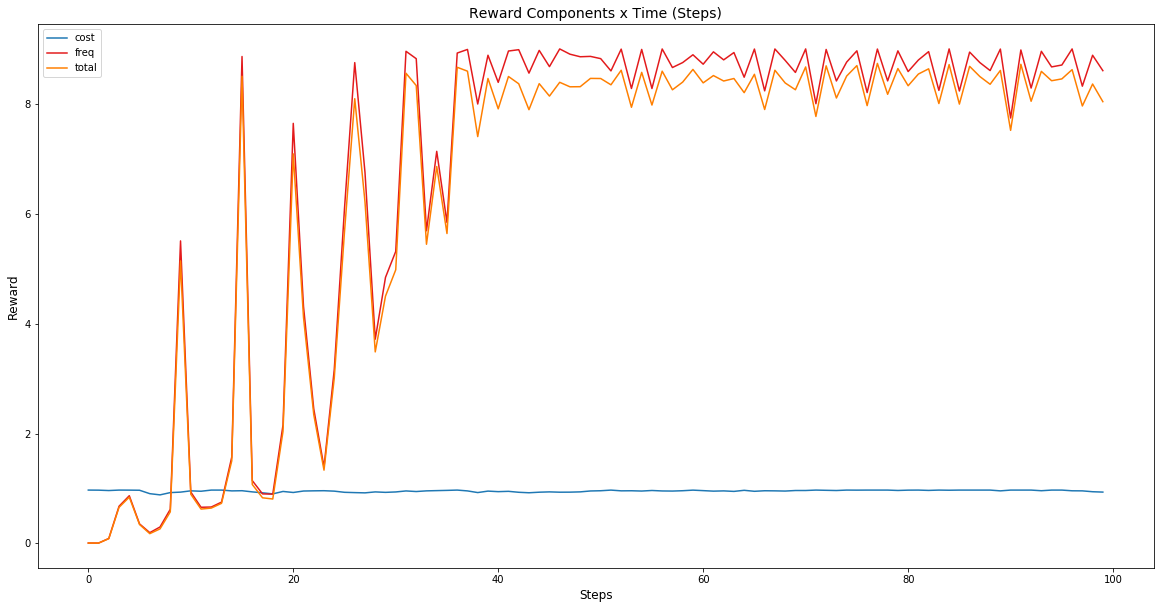

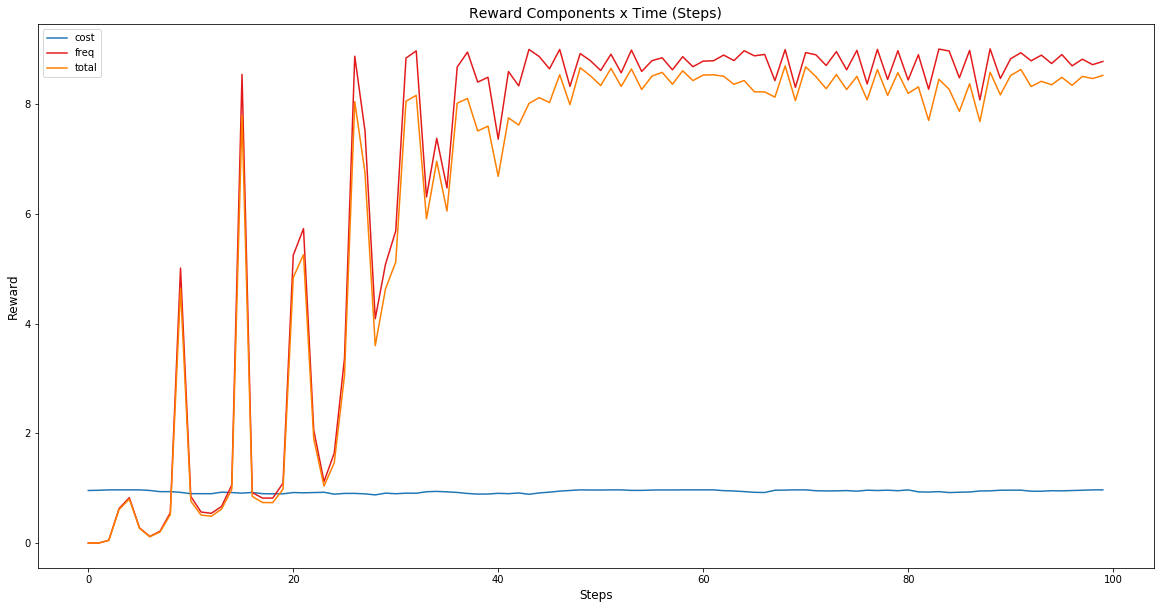

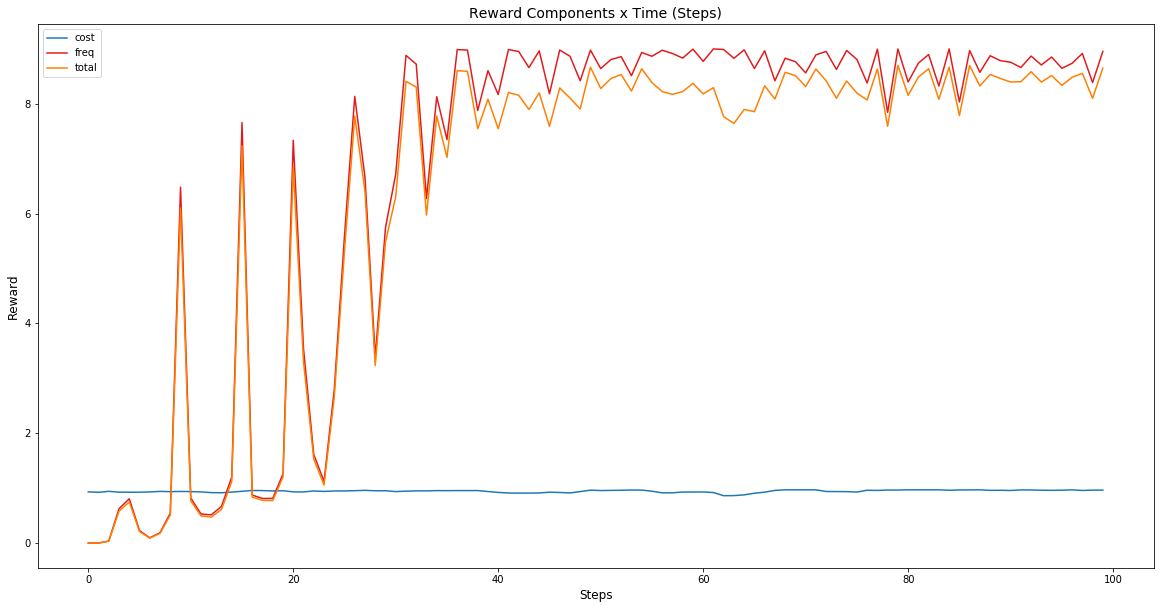

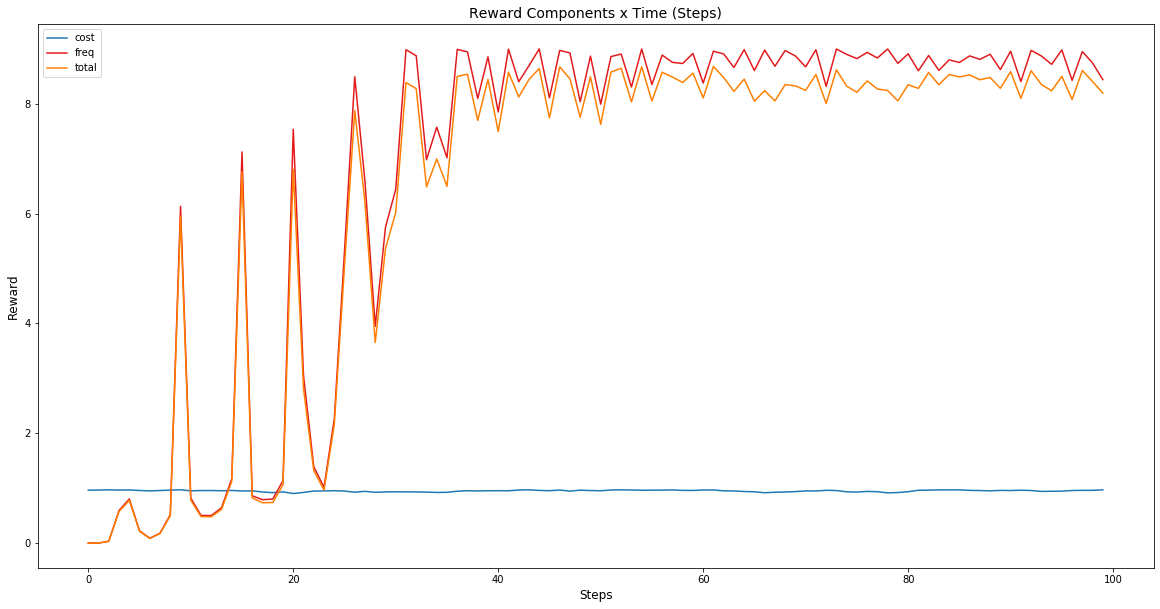

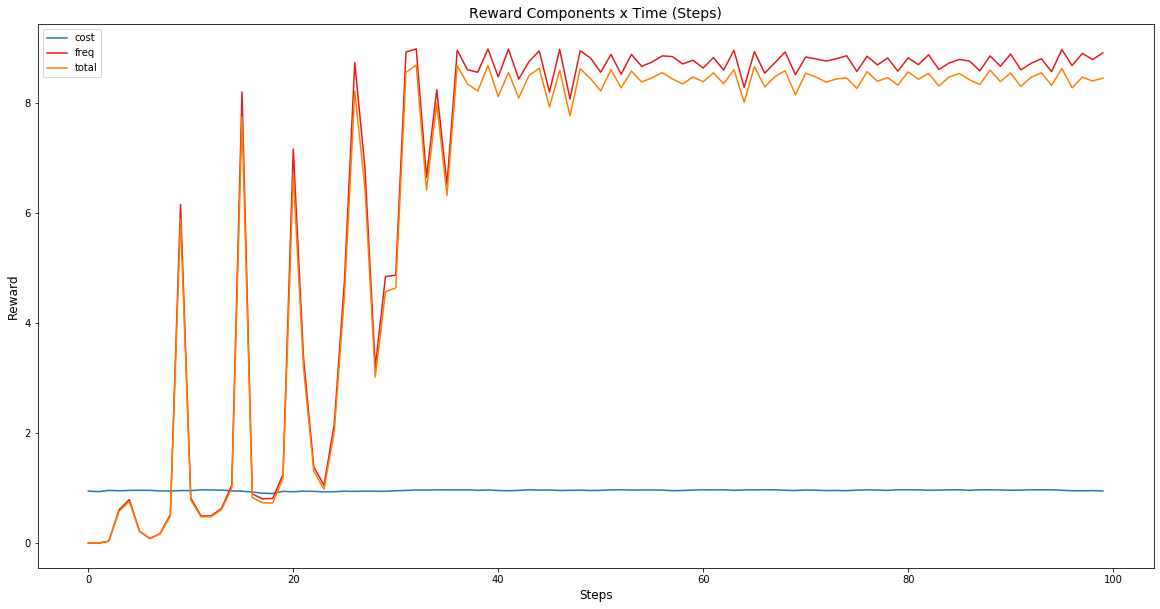

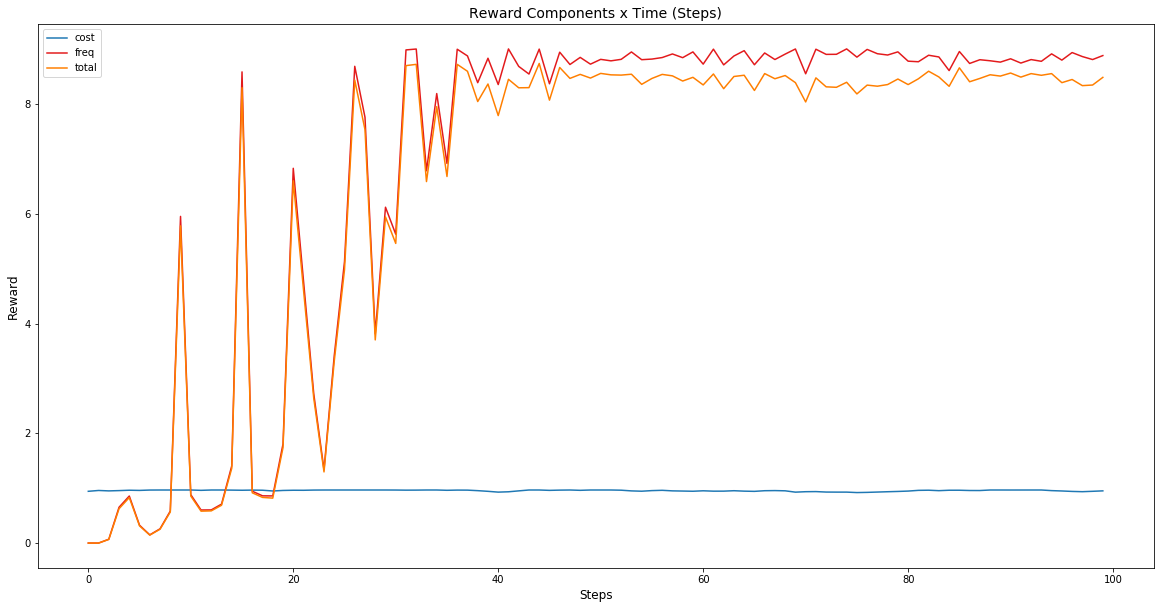

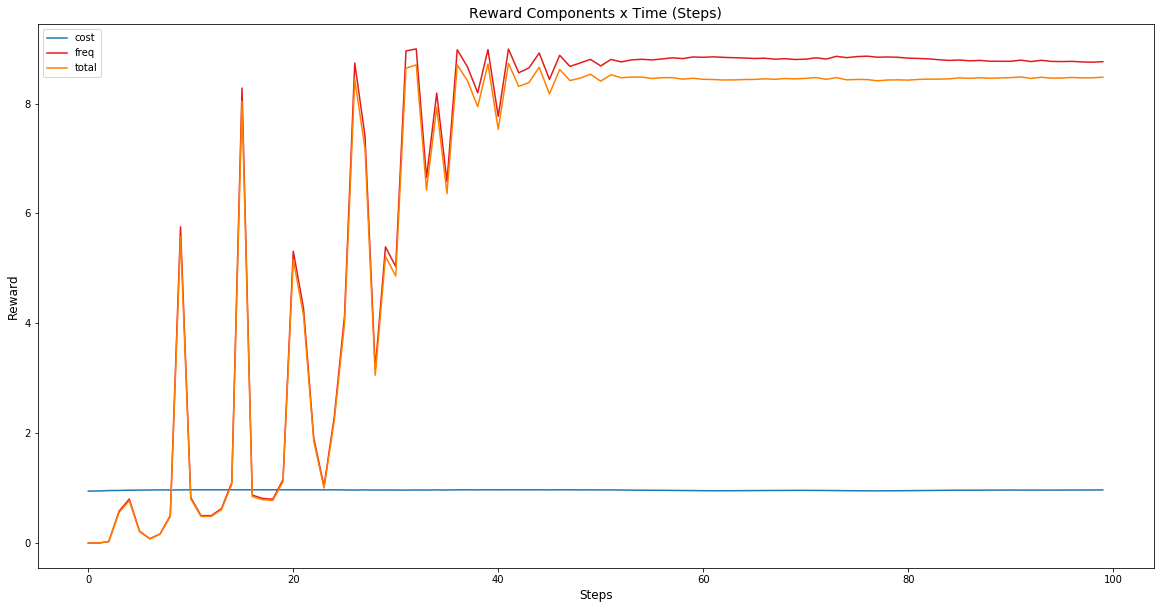

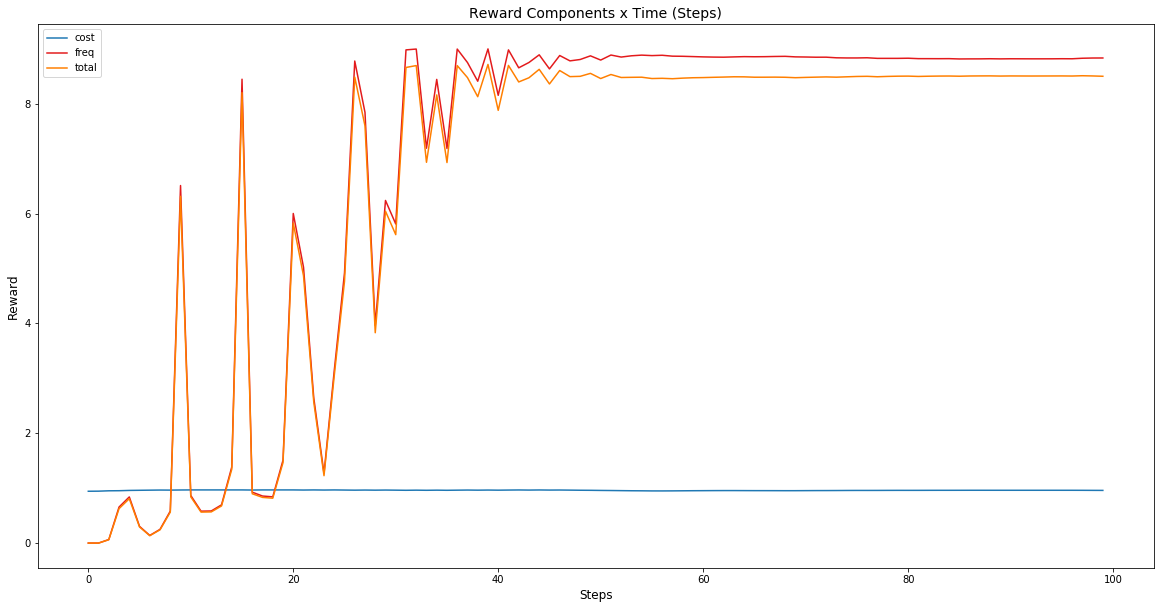

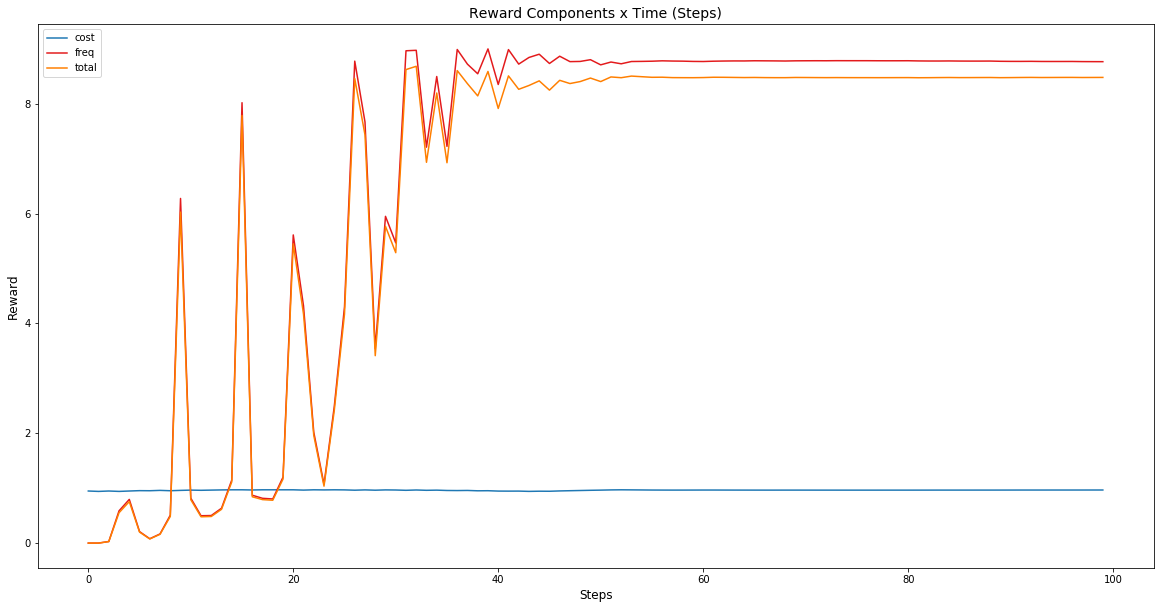

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

2365.992454121744

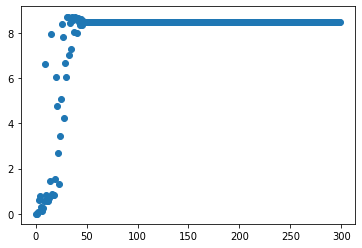

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

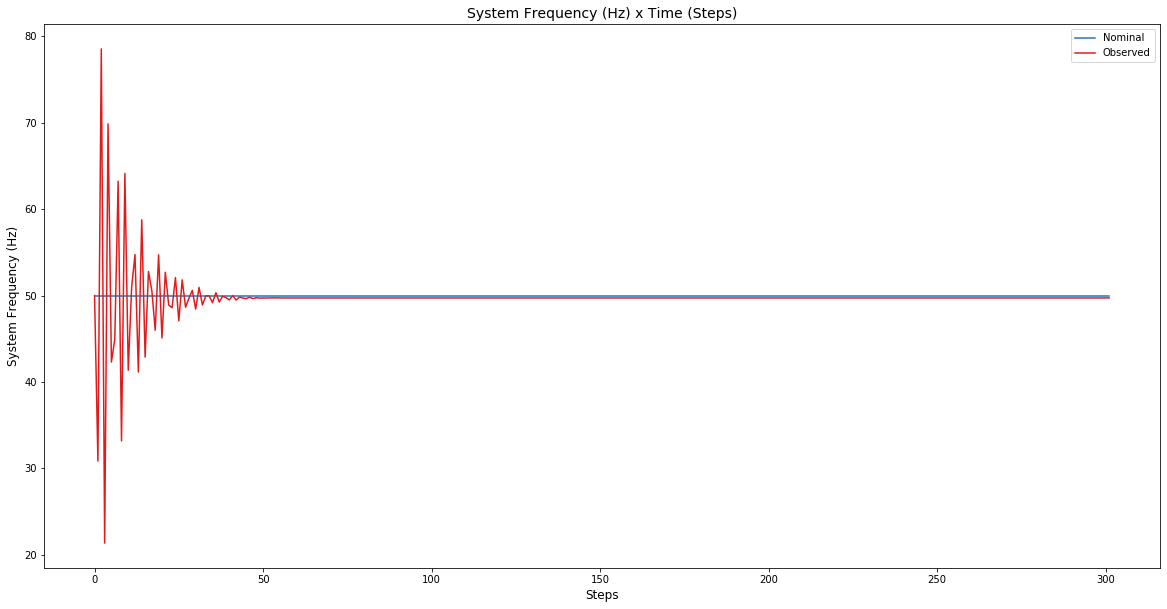

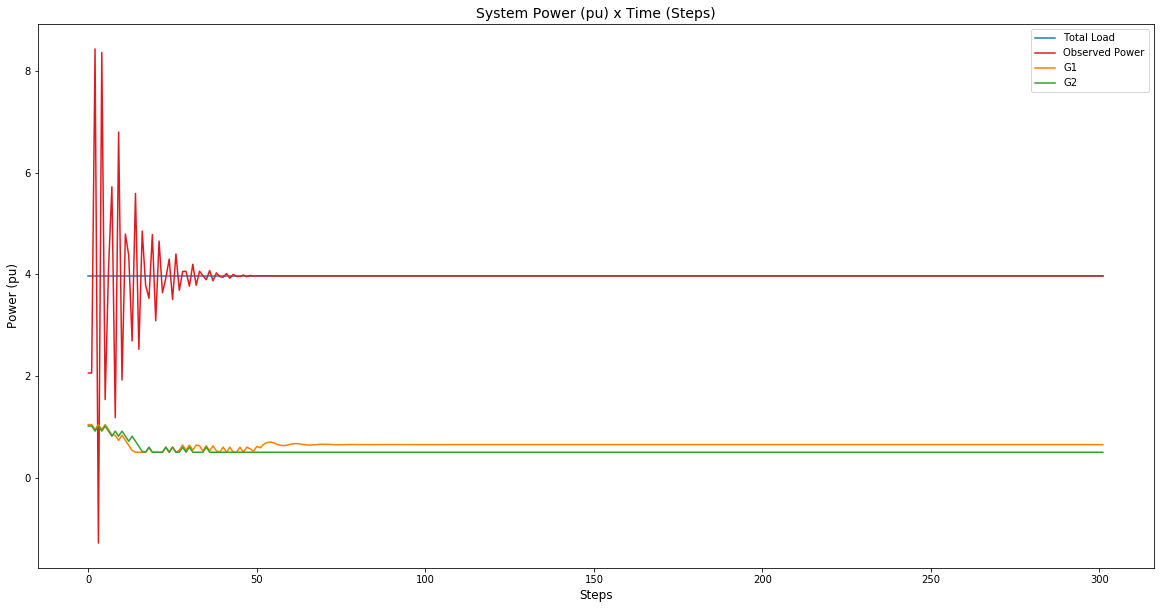

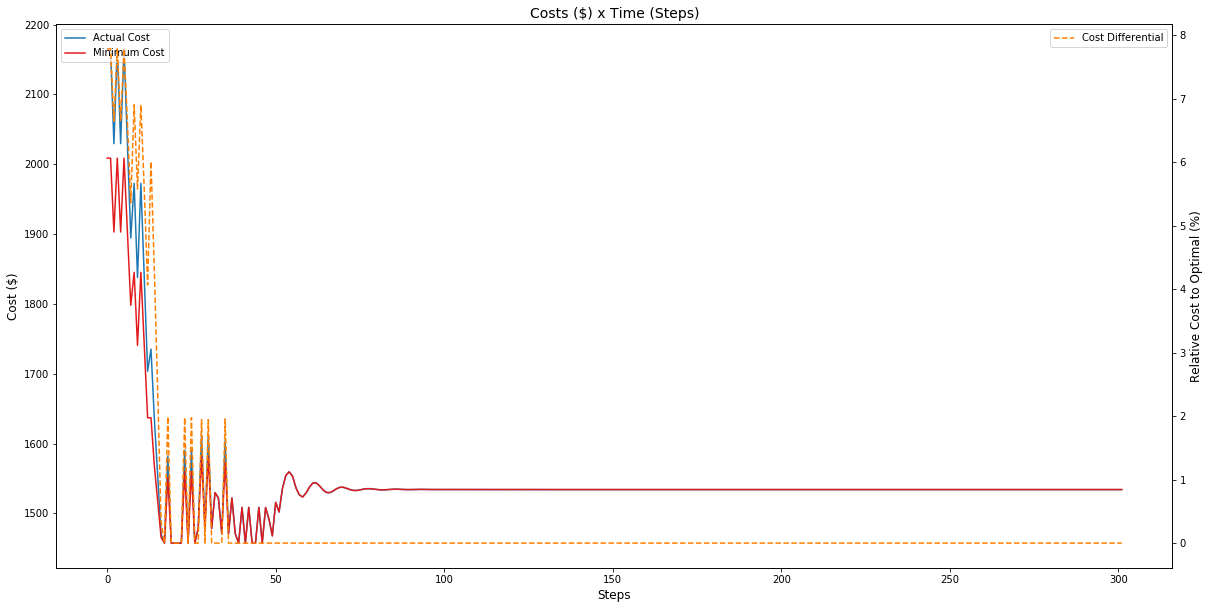

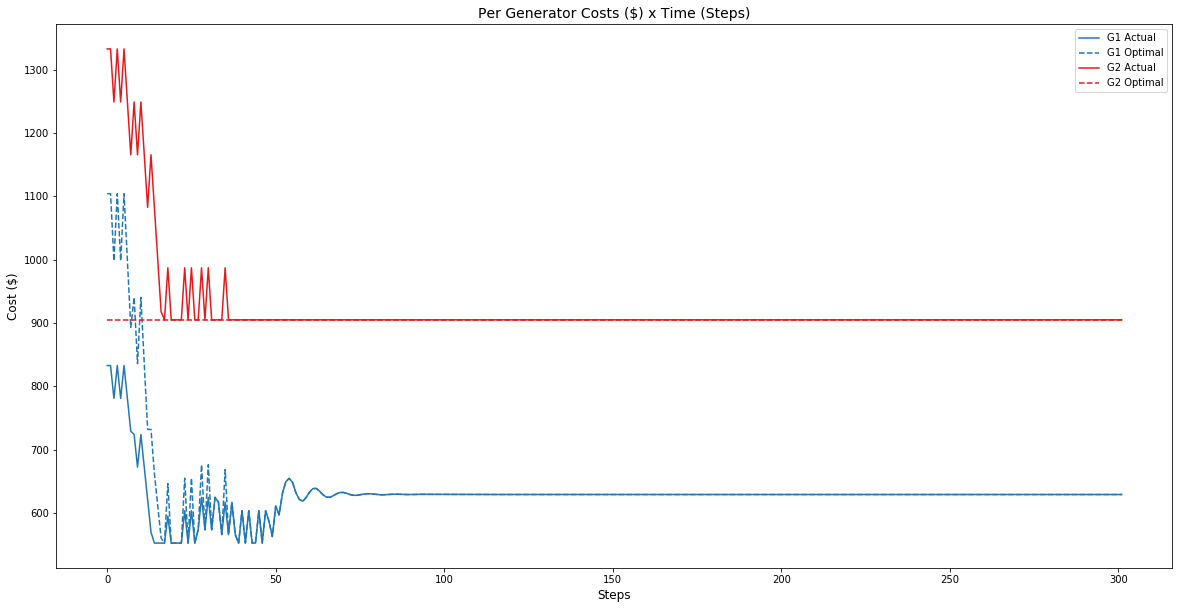

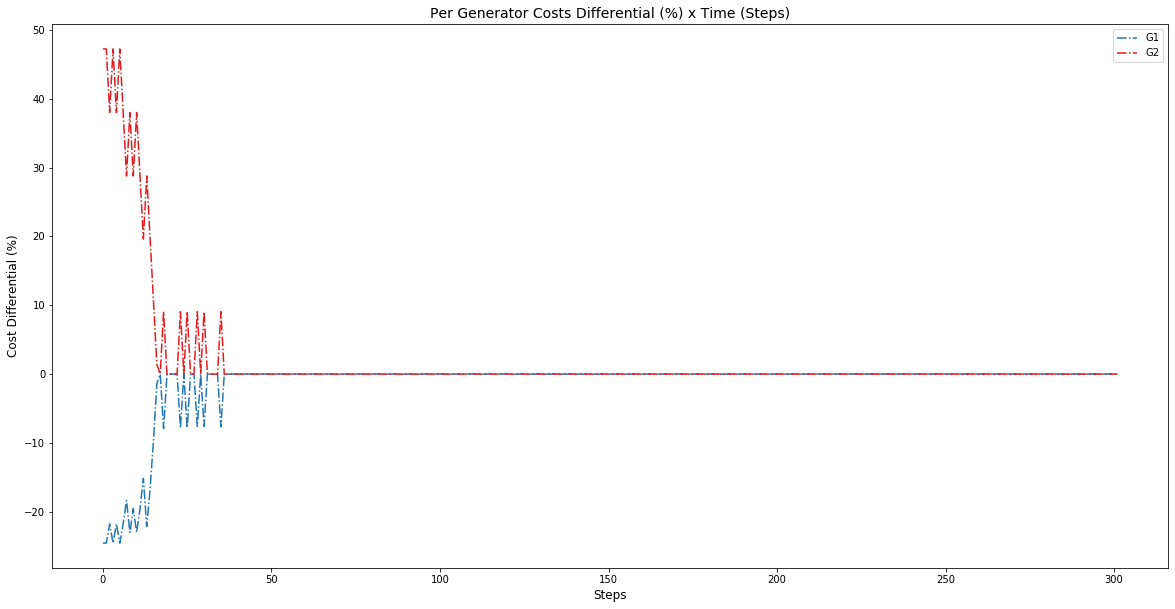

In [13]:
plotAll(electricalSystem.systemHistory)

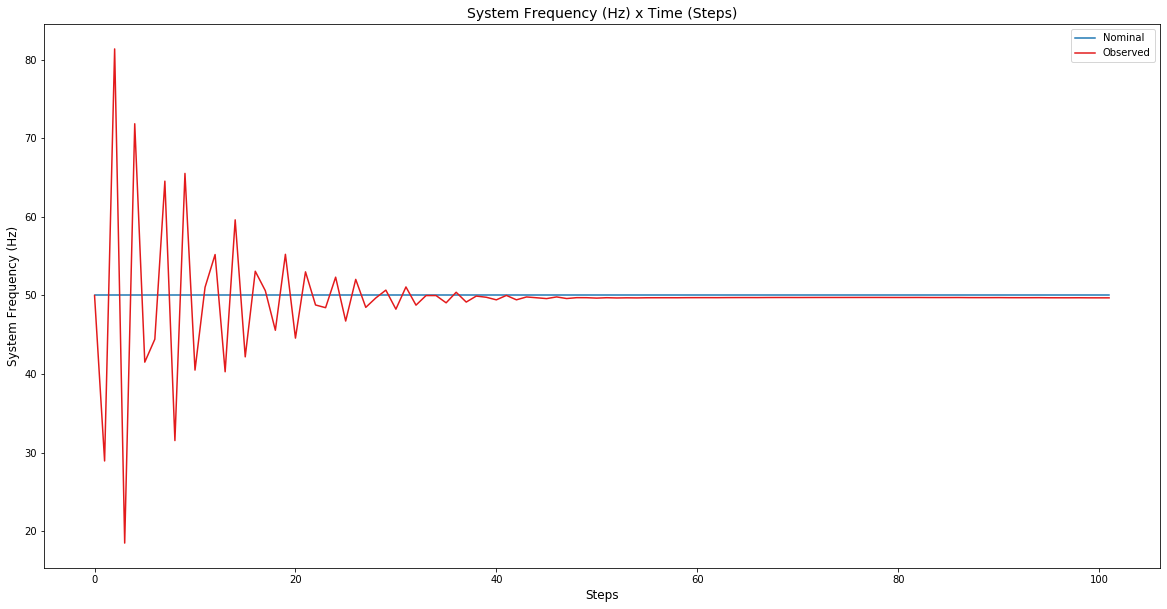

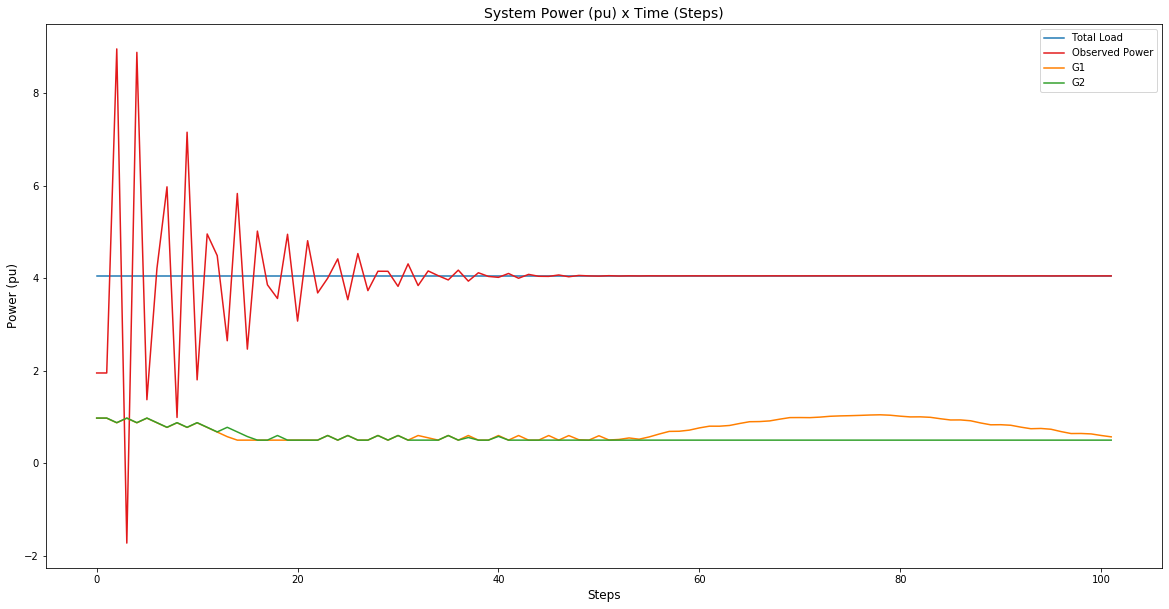

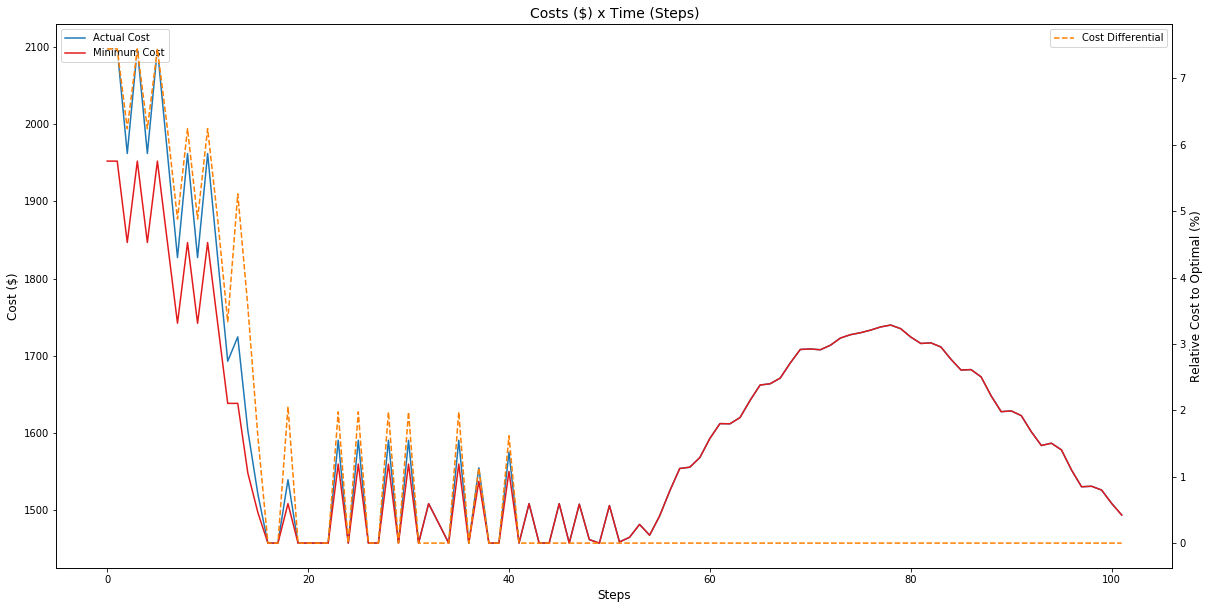

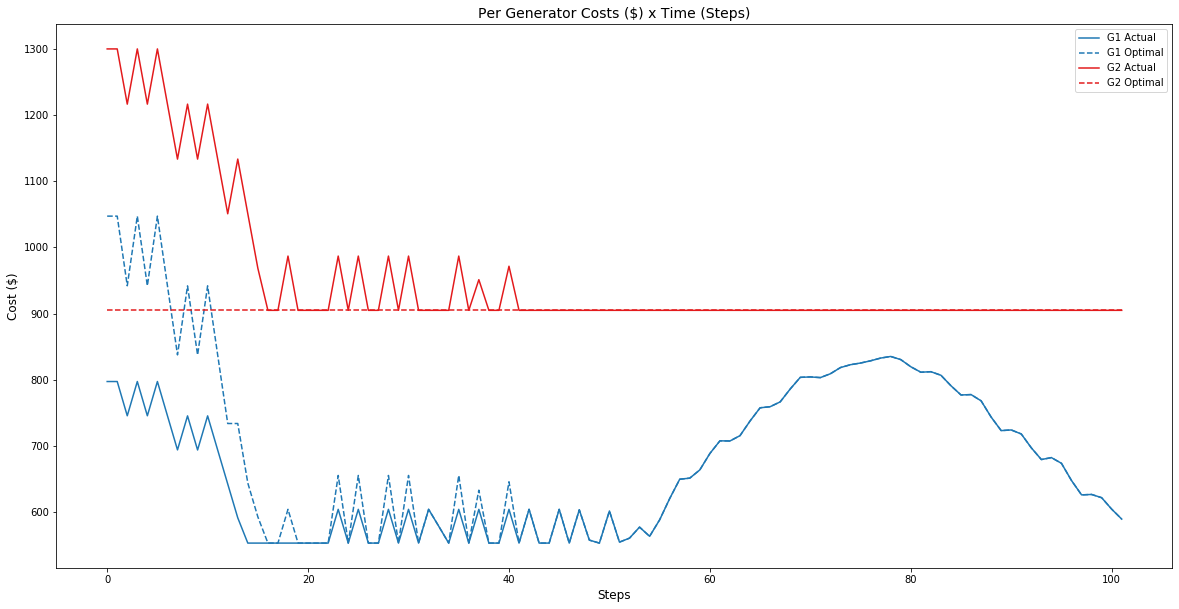

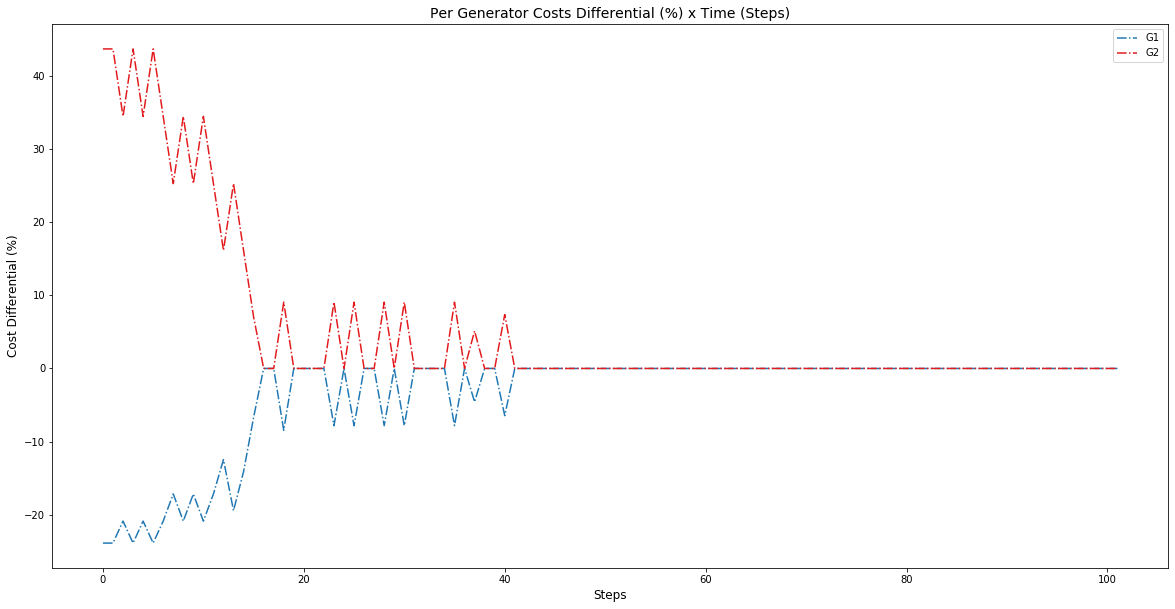

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.9709861480014923,
   'freq': 0.007297478631106717,
   'total': 0.007085750666141514},
  {'cost': 0.9696553743305351,
   'freq': 0.00653598835306811,
   'total': 0.006337656233114276},
  {'cost': 0.9626565191624741,
   'freq': 0.09055074038027928,
   'total': 0.08716926054206454},
  {'cost': 0.9709861480014923,
   'freq': 0.6768903941545595,
   'total': 0.6572511964393476},
  {'cost': 0.9701307939052806,
   'freq': 0.8684071232657677,
   'total': 0.84246849192682},
  {'cost': 0.9681059301042616,
   'freq': 0.3557399995633321,
   'total': 0.3443940031525492},
  {'cost': 0.9057730473606419,
   'freq': 0.19643478245885118,
   'total': 0.1779253315153784},
  {'cost': 0.8838351605157402,
   'freq': 0.29982892968953,
   'total': 0.26499935019940835},
  {'cost': 0.9252518445193266,
   'freq': 0.6216201963727502,
   'total': 0.5751552332843531},
  {'cost': 0.9338661992391384,
   'freq': 5.505762134271453,
   'total': 5.141645158246849},
  {'cost': 0.9572829167825896,
   'freq': 0.9

TypeError: float() argument must be a string or a number, not 'dict'

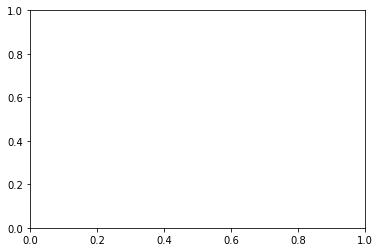

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()